In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

## Carregar os dados já Tratados

In [2]:
df_costs = pd.read_csv('../bagging/aula/healthcosts_cleaned.csv')

In [3]:
df_costs.head()

,age,sex,bmi,children,smoker,region,medical charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


In [4]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1338 non-null   int64  
 1   sex              1338 non-null   object 
 2   bmi              1338 non-null   float64
 3   children         1338 non-null   int64  
 4   smoker           1338 non-null   int64  
 5   region           1338 non-null   object 
 6   medical charges  1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


## Preparação dos dados

In [5]:
X = df_costs.drop(columns=['medical charges'], axis=1)
y = df_costs['medical charges']

In [6]:
import joblib 

preprocessor = joblib.load('../bagging/aula/preprocessor_dataset_healthcosts.pkl')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [9]:
print(f'Dados de Treinamento : {X_train.shape}')
print(f'Dados de Teste : {X_test.shape}')

Dados de Treinamento : (1070, 10)
Dados de Teste : (268, 10)


## Treinamento do modelo

In [10]:
# Criar o objeto de voting regressor

lr_model = LinearRegression()
elastic_model = ElasticNet(random_state=51)
tree_model = DecisionTreeRegressor(random_state=51)

voting_model = VotingRegressor(
    estimators=[
        ('linear regression', lr_model),
        ('elastic', elastic_model),
        ('decision tree', tree_model)
    ]
)


In [11]:
# Treinar o modelo
voting_model.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingRegressor`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('linear regression', ...), ('elastic', ...), ...]"
,"weights weights: array-like of shape (n_regressors,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted values before averaging. Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False
,"alpha alpha: float, default=1.0Constant that multiplies the penalty terms. Defaults to 1.0.See the notes for the exact mathematical meaning of thisparameter. ``alpha = 0`` is equivalent to an ordinary least square,solved by the :class:`LinearRegression` object. For numericalreasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.Given this, you should use the :class:`LinearRegression` object.",1.0
,"l1_ratio l1_ratio: float, default=0.5The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` itis an L1 penalty. For ``0 < l1_ratio < 1``, the penalty is acombination of L1 and L2.",0.5


## Análise dos resultados

In [12]:
y_pred = voting_model.predict(X_test)

In [13]:
# Calcular métricas
rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

In [14]:
print(f'Root Mean Squered Error: {rmse}')
print(f'R2: {r2}')

Root Mean Squered Error: 5443.355555669387
R2: 0.8091442073585841


In [15]:
# Calcular a importância considerando os modelos do stacking regressor

importances = []

for estimator in voting_model.estimators_:
    # Uso em modelos lineares
    if hasattr(estimator, 'coef_'):
        importances.append(np.abs(estimator.coef_))
    
    # Uso em modelos de árvore
    elif hasattr(estimator, 'feature_importances_'):
        importances.append(estimator.feature_importances_)
    
    else:
        print(f'Não foi possivel carregar a importância das variáveis do modelo {type(estimator).__name__}')



In [16]:
# Calcular a média das importâncias
importances_media = np.mean(importances, axis=0)

# Normalizar
feature_importance = importances_media/np.sum(importances_media)

In [17]:
# Obter os nomes das features
feature_names = preprocessor.get_feature_names_out()

In [18]:
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

In [19]:
df_importance = df_importance.sort_values(by='Importance', ascending=True)

df_importance.head()

,Feature,Importance
5,cat__sex_male,0.004335
4,cat__sex_female,0.004336
7,cat__region_northwest,0.005208
8,cat__region_southeast,0.010912
9,cat__region_southwest,0.018062


In [20]:
# Plotar

fig = px.bar(df_importance, x='Importance', y='Feature', title='Importância das Features - Stacking regressor', orientation='h')

fig.show()

## Propriedades do modelo

In [22]:
# Mostrar evidências do modelo
# Fazer uma predição num exemplo específico

X_sample = X_test[7].reshape(1, -1)

# Predições individuais dos estimadores
lr_pred = voting_model.named_estimators_['linear regression'].predict(X_sample)
elatic_pred = voting_model.named_estimators_['elastic'].predict(X_sample)
tree_pred = voting_model.named_estimators_['decision tree'].predict(X_sample)

# Predição final com o Stacking
voting_pred = voting_model.predict(X_sample)

In [25]:
# Exibir os resultados
print(f'Predição do Linear Regression: {lr_pred[0]}')
print(f'Predição do ElasticNet: {elatic_pred[0]}')
print(f'Predição da Árvore de Decisão: {tree_pred[0]}')
print(f'Predição Final do Voting: {voting_pred[0]}')

Predição do Linear Regression: 16903.450286619413
Predição do ElasticNet: 15618.39434590673
Predição da Árvore de Decisão: 14692.66935
Predição Final do Voting: 15738.171327508715


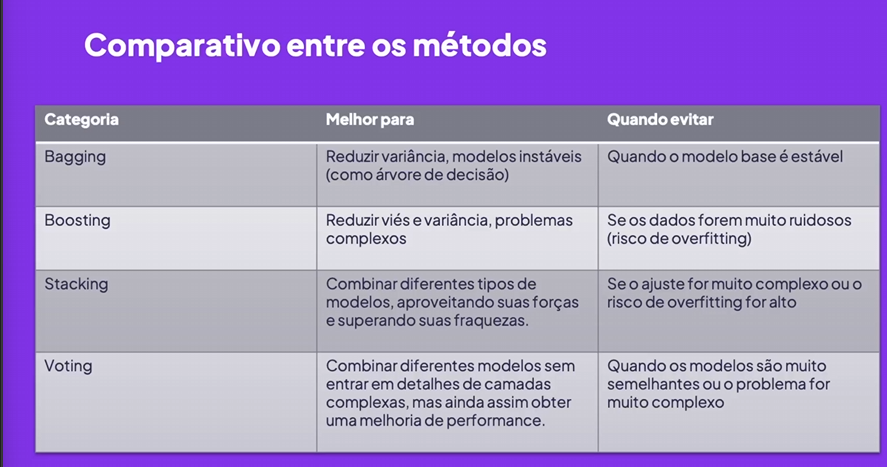